# Modélisation prédictive des segments clients

L’objectif de ce notebook est de développer un modèle supervisé capable
de prédire le segment d’appartenance d’un client à partir de ses
caractéristiques comportementales.

Cette approche permet d’industrialiser la segmentation client et de
segmenter de nouveaux clients de manière automatisée.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler


In [2]:
PROJECT_DIR = Path.cwd().parent
INTERIM_DIR = PROJECT_DIR / "data" / "interim"

client_data = pd.read_parquet(
    INTERIM_DIR / "client_features_with_clusters.parquet"
)

client_data.shape


(93358, 10)

In [3]:
# definition de X et Y
y = client_data["cluster"]


In [4]:
# varaibles explicatives
features = [
    "recency",
    "frequency",
    "monetary",
    "avg_basket",
    "total_items",
    "avg_delivery_delay",
    "avg_review_score",
    "nb_categories"
]

X = client_data[features]


In [5]:
# train et test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [6]:
# Scaling
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
# verification 
print("Train:", X_train_scaled.shape)
print("Test :", X_test_scaled.shape)

y_train.value_counts(normalize=True)


Train: (74686, 8)
Test : (18672, 8)


cluster
0    0.754934
2    0.162681
3    0.074150
1    0.008234
Name: proportion, dtype: float64

# Entraînement du modèle supervisé (Random Forest)

### Entrainement du modèle

In [8]:
from sklearn.ensemble import RandomForestClassifier


In [9]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",10
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metri

### prediction sur le jeu test

In [10]:
y_pred = rf_model.predict(X_test_scaled)


### Evaluation globale

In [11]:
from sklearn.metrics import classification_report, accuracy_score


In [12]:
print("Accuracy globale :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy globale : 0.9964117395029991
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14096
           1       1.00      1.00      1.00       153
           2       0.99      0.99      0.99      3038
           3       0.97      0.99      0.98      1385

    accuracy                           1.00     18672
   macro avg       0.99      1.00      0.99     18672
weighted avg       1.00      1.00      1.00     18672



### Matrice de confusion

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


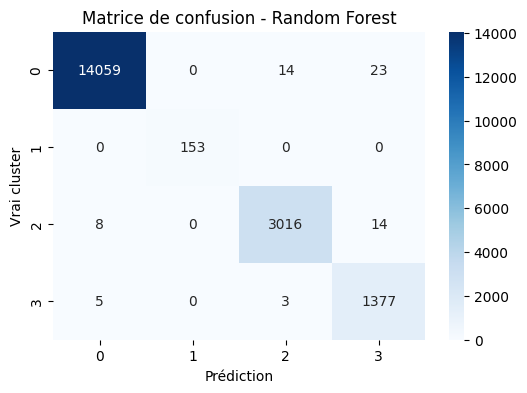

In [14]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédiction")
plt.ylabel("Vrai cluster")
plt.title("Matrice de confusion - Random Forest")
plt.show()


Les performances élevées du modèle supervisé s’expliquent par le fait que
la variable cible (cluster) a été construite à partir des mêmes variables
explicatives utilisées pour l’entraînement du modèle.

Le modèle ne vise donc pas à découvrir de nouvelles relations, mais à
reproduire de manière fiable la segmentation existante afin de permettre
l’assignation de nouveaux clients à un segment sans relancer un algorithme
de clustering.


## Validation par cross-validation

In [15]:
from sklearn.model_selection import StratifiedKFold, cross_val_score


### Définition de la stratégie de CV

- StratifiedKFold obligatoire (clusters déséquilibrés)

In [16]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)


### Cross-validation sur le jeu d’entraînement

In [17]:
cv_scores = cross_val_score(
    rf_model,
    X_train_scaled,
    y_train,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1
)


### resultats

In [18]:
cv_scores


array([0.99626171, 0.99692799, 0.9947289 , 0.9965921 , 0.9961313 ])

In [19]:
print("F1 weighted moyen :", cv_scores.mean())
print("Écart-type        :", cv_scores.std())


F1 weighted moyen : 0.9961284003617725
Écart-type        : 0.0007524297885868688


La validation par cross-validation stratifiée confirme la robustesse du
modèle. Les scores F1 pondérés sont élevés et homogènes entre les folds,
avec un écart-type très faible, indiquant que les performances du modèle
ne dépendent pas d’un découpage particulier des données.

Ces résultats confirment que le modèle est capable de reproduire de
manière stable la segmentation existante, objectif principal de cette
approche supervisée.


# Importance globale des variables

In [20]:
import pandas as pd

feature_importance = pd.DataFrame({
    "feature": features,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)

feature_importance


,feature,importance
2,monetary,0.389703
3,avg_basket,0.307816
6,avg_review_score,0.246399
5,avg_delivery_delay,0.038814
4,total_items,0.008071
0,recency,0.005000
1,frequency,0.003100
7,nb_categories,0.001096


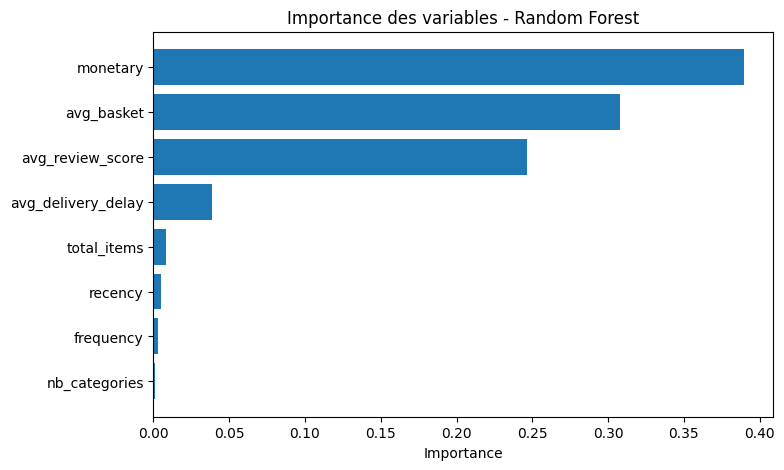

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh(
    feature_importance["feature"],
    feature_importance["importance"]
)
plt.gca().invert_yaxis()
plt.title("Importance des variables - Random Forest")
plt.xlabel("Importance")
plt.show()


L’analyse des importances des variables montre que la segmentation client
est principalement structurée par la valeur économique du client, mesurée
par la dépense totale (monetary) et le panier moyen (avg_basket). Ces deux
variables concentrent à elles seules l’essentiel du pouvoir discriminant.

La satisfaction client, mesurée par la note moyenne des avis, joue également
un rôle significatif, indiquant que l’expérience vécue par le client
contribue à différencier les segments au-delà de la simple valeur monétaire.

Les variables de récence, de fréquence et de diversité des catégories
présentent une importance plus faible, ce qui s’explique par une forte
concentration des comportements (achats ponctuels) et par des redondances
avec les indicateurs de valeur.
